# Skin Lesion Classification — Transfer Learning
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```

**Model:** EfficientNet-B0

In [1]:
# Environment & imports
# If running in a fresh environment, you may need to install packages:
# !pip install torch torchvision matplotlib scikit-learn tqdm timm -q
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Note: you may need to restart the kernel to use updated packages.
Device: cpu
Device: cpu


In [2]:
# Paths (change these to your dataset locations)
train_dir = r"D:\archive\train"
val_dir   = r"D:\archive\val"

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (14): ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 29322  Val size: 3660


In [3]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 2658, 2099, 900, 792, 191, 1932, 1368, 660, 10300, 3617, 3408, 502, 202]
Class weights: tensor([ 42.3117,  11.0316,  13.9695,  32.5800,  37.0227, 153.5183,  15.1770,
         21.4342,  44.4273,   2.8468,   8.1067,   8.6039,  58.4104, 145.1584])


In [4]:
# EfficientNet-B0 (torchvision if available)
try:
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # If torchvision doesn't have efficientnet in your environment, use timm (uncomment install if needed)
    # !pip install timm -q
    import timm
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
model = model.to(device)


c:\Users\nethm\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nethm\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 20  # change as needed


In [6]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [7]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="EfficientNet-B0")


Epoch 1/20


100%|██████████| 917/917 [25:15<00:00,  1.65s/it]



train Loss: 1.3807 Acc: 0.5308 F1: 0.4387


100%|██████████| 115/115 [01:04<00:00,  1.78it/s]



val Loss: 0.9237 Acc: 0.6699 F1: 0.6122
------------------------------
Epoch 2/20


100%|██████████| 917/917 [24:31<00:00,  1.60s/it]


train Loss: 0.9138 Acc: 0.6376 F1: 0.5662


100%|██████████| 115/115 [01:02<00:00,  1.85it/s]



val Loss: 0.7819 Acc: 0.7224 F1: 0.6712
------------------------------
Epoch 3/20


100%|██████████| 917/917 [24:37<00:00,  1.61s/it]


train Loss: 0.7776 Acc: 0.6758 F1: 0.6170


100%|██████████| 115/115 [01:01<00:00,  1.86it/s]



val Loss: 0.6643 Acc: 0.7530 F1: 0.7072
------------------------------
Epoch 4/20


100%|██████████| 917/917 [24:09<00:00,  1.58s/it]



train Loss: 0.7036 Acc: 0.6997 F1: 0.6470


100%|██████████| 115/115 [01:00<00:00,  1.91it/s]



val Loss: 0.7162 Acc: 0.7380 F1: 0.7174
------------------------------
Epoch 5/20


100%|██████████| 917/917 [24:20<00:00,  1.59s/it]



train Loss: 0.6443 Acc: 0.7194 F1: 0.6741


100%|██████████| 115/115 [01:01<00:00,  1.86it/s]



val Loss: 0.6007 Acc: 0.7740 F1: 0.7514
------------------------------
Epoch 6/20


100%|██████████| 917/917 [24:04<00:00,  1.58s/it]


train Loss: 0.5942 Acc: 0.7361 F1: 0.6950


100%|██████████| 115/115 [01:01<00:00,  1.88it/s]



val Loss: 0.5575 Acc: 0.7956 F1: 0.7582
------------------------------
Epoch 7/20


100%|██████████| 917/917 [24:20<00:00,  1.59s/it]


train Loss: 0.5613 Acc: 0.7446 F1: 0.7038


100%|██████████| 115/115 [01:01<00:00,  1.88it/s]



val Loss: 0.5394 Acc: 0.7992 F1: 0.7710
------------------------------
Epoch 8/20


100%|██████████| 917/917 [24:07<00:00,  1.58s/it]



train Loss: 0.5418 Acc: 0.7503 F1: 0.7086


100%|██████████| 115/115 [01:00<00:00,  1.90it/s]


val Loss: 0.5753 Acc: 0.7863 F1: 0.7557
------------------------------
Epoch 9/20


100%|██████████| 917/917 [24:07<00:00,  1.58s/it]



train Loss: 0.5165 Acc: 0.7603 F1: 0.7214


100%|██████████| 115/115 [01:01<00:00,  1.87it/s]



val Loss: 0.4957 Acc: 0.8145 F1: 0.7893
------------------------------
Epoch 10/20


100%|██████████| 917/917 [24:18<00:00,  1.59s/it]


train Loss: 0.4769 Acc: 0.7702 F1: 0.7401


100%|██████████| 115/115 [01:01<00:00,  1.88it/s]



val Loss: 0.4735 Acc: 0.8257 F1: 0.8164
------------------------------
Epoch 11/20


100%|██████████| 917/917 [24:13<00:00,  1.58s/it]


train Loss: 0.4638 Acc: 0.7815 F1: 0.7531


100%|██████████| 115/115 [01:01<00:00,  1.88it/s]


val Loss: 0.4582 Acc: 0.8301 F1: 0.8083
------------------------------
Epoch 12/20


100%|██████████| 917/917 [24:16<00:00,  1.59s/it]


train Loss: 0.4483 Acc: 0.7857 F1: 0.7542


100%|██████████| 115/115 [01:01<00:00,  1.88it/s]


val Loss: 0.4615 Acc: 0.8251 F1: 0.8027
------------------------------
Epoch 13/20


100%|██████████| 917/917 [24:12<00:00,  1.58s/it]


train Loss: 0.4285 Acc: 0.7908 F1: 0.7629


100%|██████████| 115/115 [01:01<00:00,  1.88it/s]


val Loss: 0.4796 Acc: 0.8251 F1: 0.7918
------------------------------
Epoch 14/20


100%|██████████| 917/917 [24:07<00:00,  1.58s/it]


train Loss: 0.4129 Acc: 0.7950 F1: 0.7655


100%|██████████| 115/115 [01:00<00:00,  1.90it/s]



val Loss: 0.4245 Acc: 0.8434 F1: 0.8418
------------------------------
Epoch 15/20


100%|██████████| 917/917 [23:46<00:00,  1.56s/it]


train Loss: 0.3871 Acc: 0.8082 F1: 0.7886


100%|██████████| 115/115 [01:01<00:00,  1.87it/s]


val Loss: 0.4612 Acc: 0.8339 F1: 0.8230
------------------------------
Epoch 16/20


100%|██████████| 917/917 [23:48<00:00,  1.56s/it]


train Loss: 0.3959 Acc: 0.8006 F1: 0.7768


100%|██████████| 115/115 [00:59<00:00,  1.92it/s]


val Loss: 0.4251 Acc: 0.8492 F1: 0.8306
------------------------------
Epoch 17/20


100%|██████████| 917/917 [23:50<00:00,  1.56s/it]


train Loss: 0.3681 Acc: 0.8118 F1: 0.7900


100%|██████████| 115/115 [01:00<00:00,  1.90it/s]


val Loss: 0.4501 Acc: 0.8363 F1: 0.8027
------------------------------
Epoch 18/20


100%|██████████| 917/917 [23:49<00:00,  1.56s/it]



train Loss: 0.3633 Acc: 0.8174 F1: 0.7936


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]


val Loss: 0.4182 Acc: 0.8443 F1: 0.8346
------------------------------
Epoch 19/20


100%|██████████| 917/917 [23:51<00:00,  1.56s/it]


train Loss: 0.3566 Acc: 0.8208 F1: 0.7999


100%|██████████| 115/115 [01:00<00:00,  1.89it/s]



val Loss: 0.4285 Acc: 0.8467 F1: 0.8421
------------------------------
Epoch 20/20


100%|██████████| 917/917 [23:47<00:00,  1.56s/it]


train Loss: 0.3340 Acc: 0.8228 F1: 0.8016


100%|██████████| 115/115 [01:00<00:00,  1.91it/s]

val Loss: 0.4125 Acc: 0.8530 F1: 0.8611
------------------------------
Training complete in 504m 5s
Best val F1: 0.8611


In [8]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


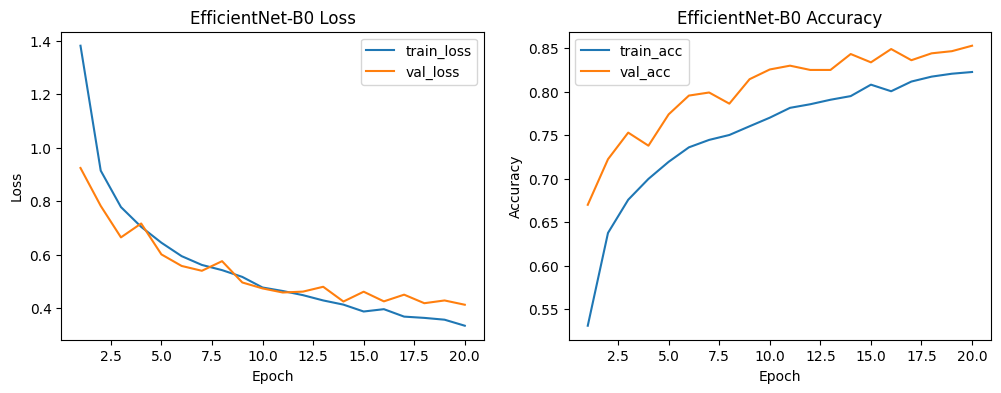

In [9]:
plot_history(history, model_name="EfficientNet-B0")


In [10]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)


In [11]:
evaluate_model(model)

                               precision    recall  f1-score   support

            Actinic keratoses       0.57      0.74      0.64        86
         Basal cell carcinoma       0.81      0.83      0.82       332
Benign keratosis-like lesions       0.63      0.81      0.71       262
                   Chickenpox       0.96      0.97      0.97       112
                       Cowpox       0.99      1.00      0.99        99
               Dermatofibroma       0.84      0.91      0.88        23
                         HFMD       0.98      1.00      0.99       241
                      Healthy       0.99      0.96      0.98       171
                      Measles       0.98      1.00      0.99        82
             Melanocytic nevi       0.90      0.83      0.86      1287
                     Melanoma       0.70      0.67      0.68       452
                    Monkeypox       0.99      0.98      0.98       426
      Squamous cell carcinoma       0.61      0.69      0.65        62
     

Note: you may need to restart the kernel to use updated packages.
Test classes order: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 3674
Loaded checkpoint: EfficientNet-B0_best.pth
                               precision    recall  f1-score   support

            Actinic keratoses       0.58      0.80      0.67        88
         Basal cell carcinoma       0.82      0.88      0.85       333
Benign keratosis-like lesions       0.66      0.78      0.72       263
                   Chickenpox       0.94      0.98      0.96       113
                       Cowpox       0.97      1.00      0.99        99
               Dermatofibroma       0.67      0.80      0.73        25
                         HFMD       0.98      1.00      0.99       242
                      Healthy       0.99  

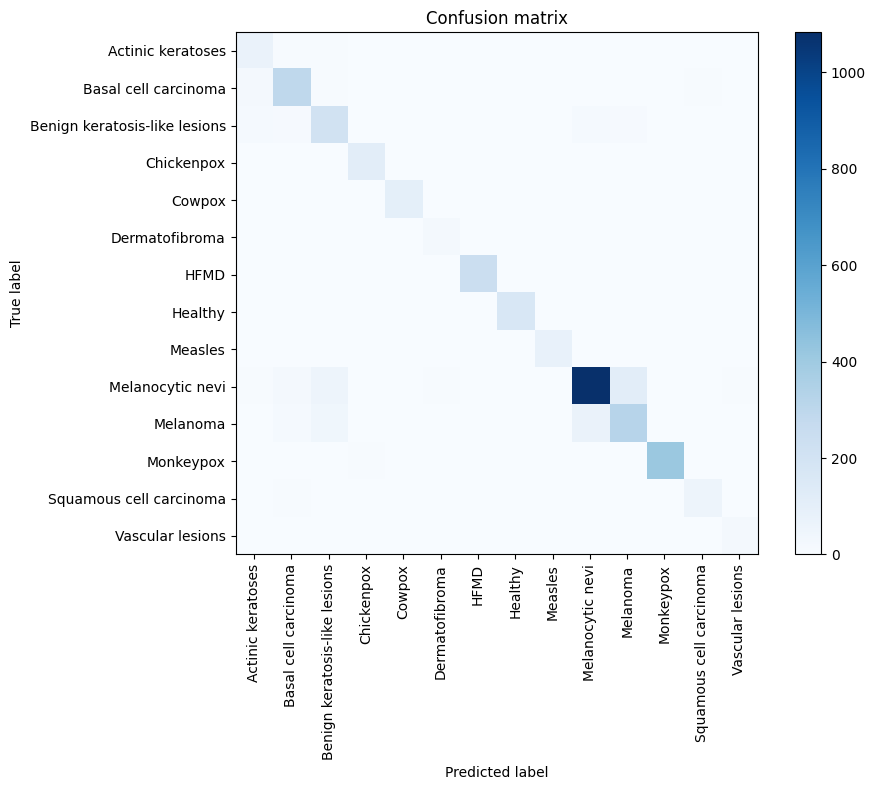

Saved test_predictions.csv


In [12]:

%pip install pandas
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# path to test data 
test_dir = r"D:\archive\test"   

# use same transforms as val_transforms to keep inputs consistent
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# load best checkpoint (if you saved it during training)
ckpt_path = "EfficientNet-B0_best.pth"   # adjust if different
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print("Loaded checkpoint:", ckpt_path)
except Exception as e:
    print("Checkpoint load failed (using current model):", e)

model.to(device)
model.eval()

y_true = []
y_pred = []
probs = []   # optional: predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# metrics
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# optional: plot confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(test_dataset.classes))
plt.xticks(tick_marks, test_dataset.classes, rotation=90)
plt.yticks(tick_marks, test_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# optional: save per-image predictions (filenames, true, pred, prob)
filenames = [p[0] for p in test_dataset.samples]  # full relative paths
df = pd.DataFrame({
    "file": filenames,
    "true": [test_dataset.classes[i] for i in y_true],
    "pred": [test_dataset.classes[i] for i in y_pred],
    "prob_top": [round(float(np.max(p)),4) for p in probs]
})
df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv")

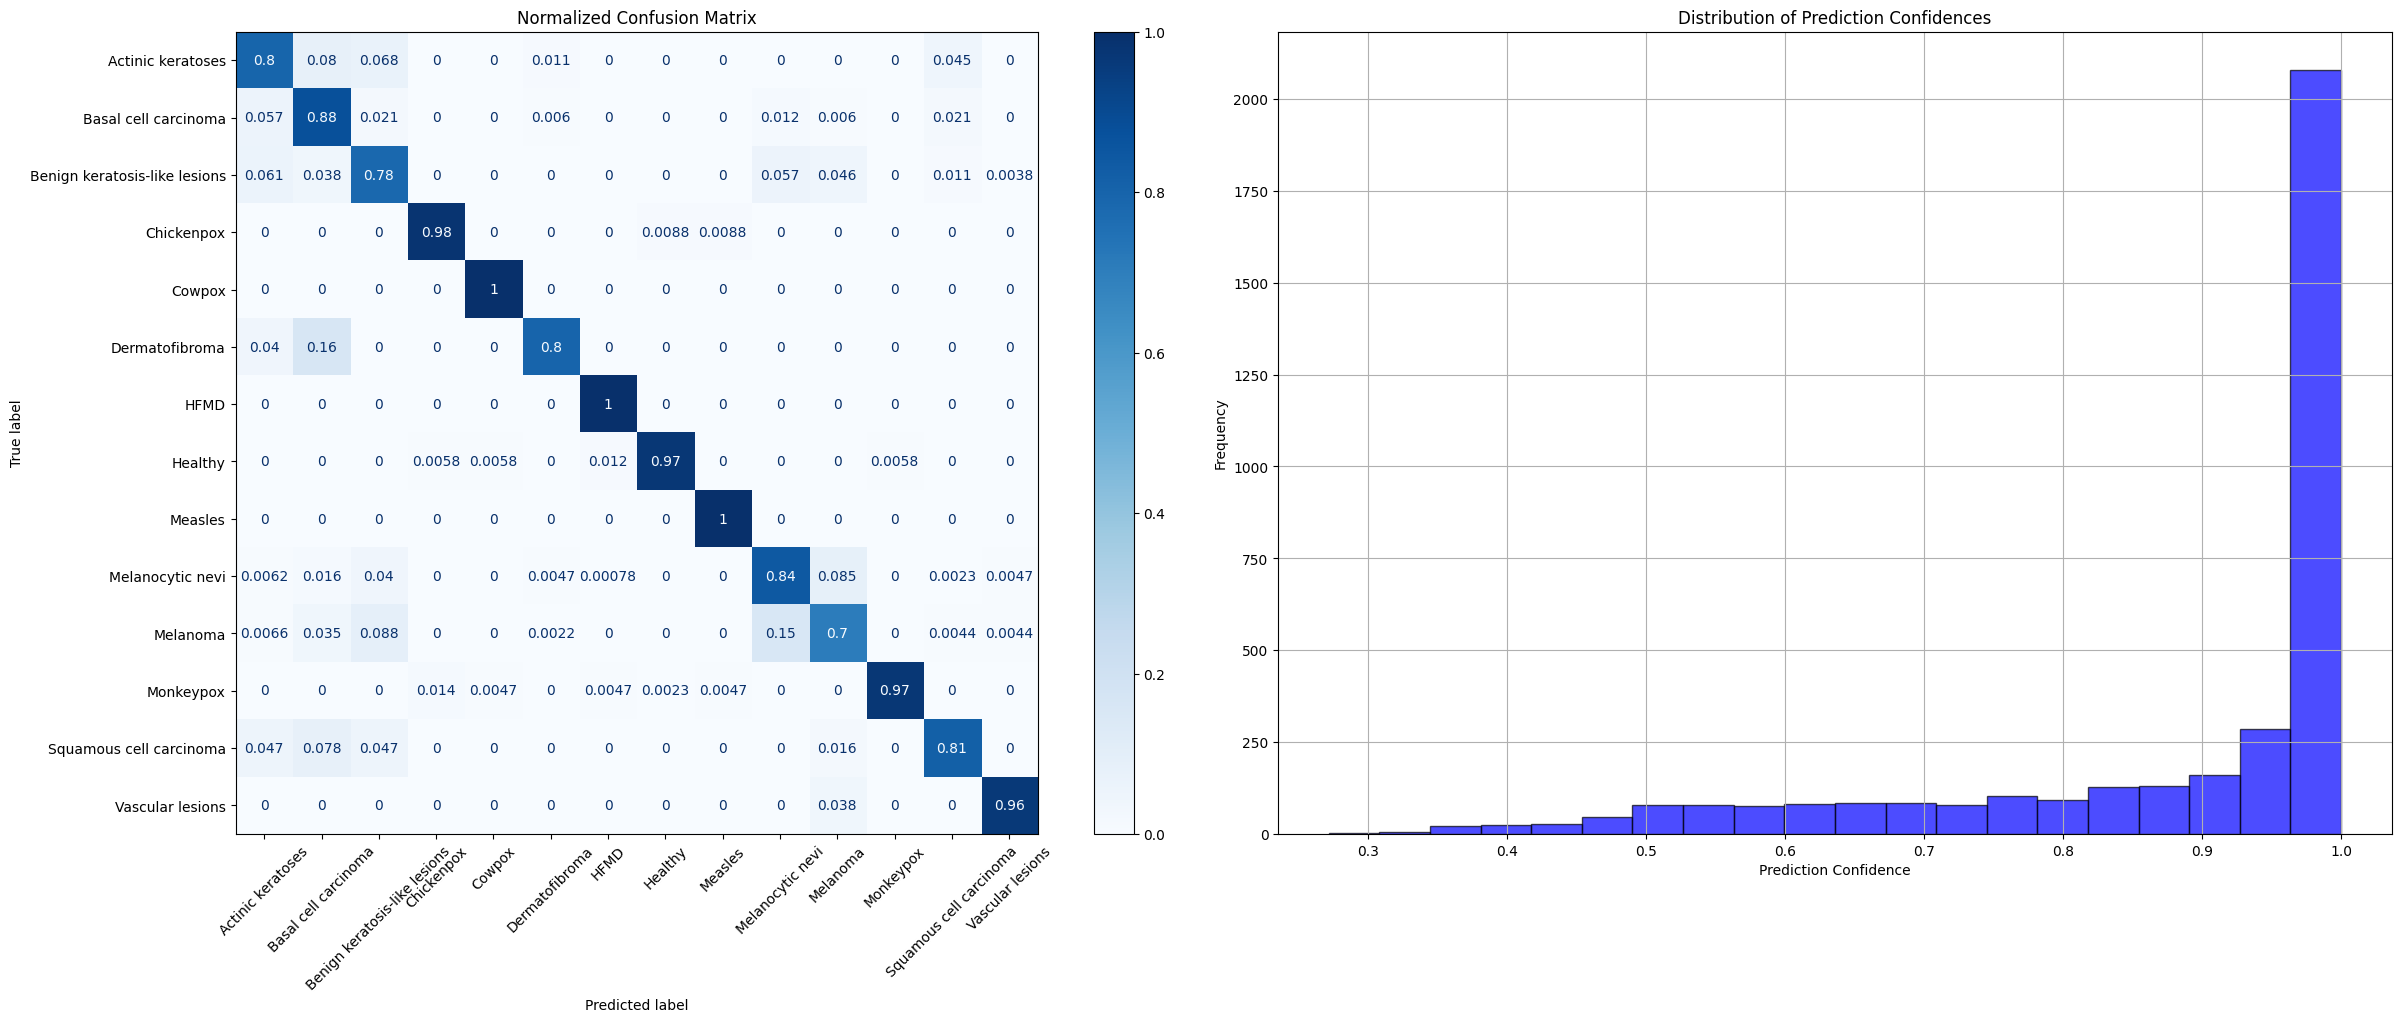

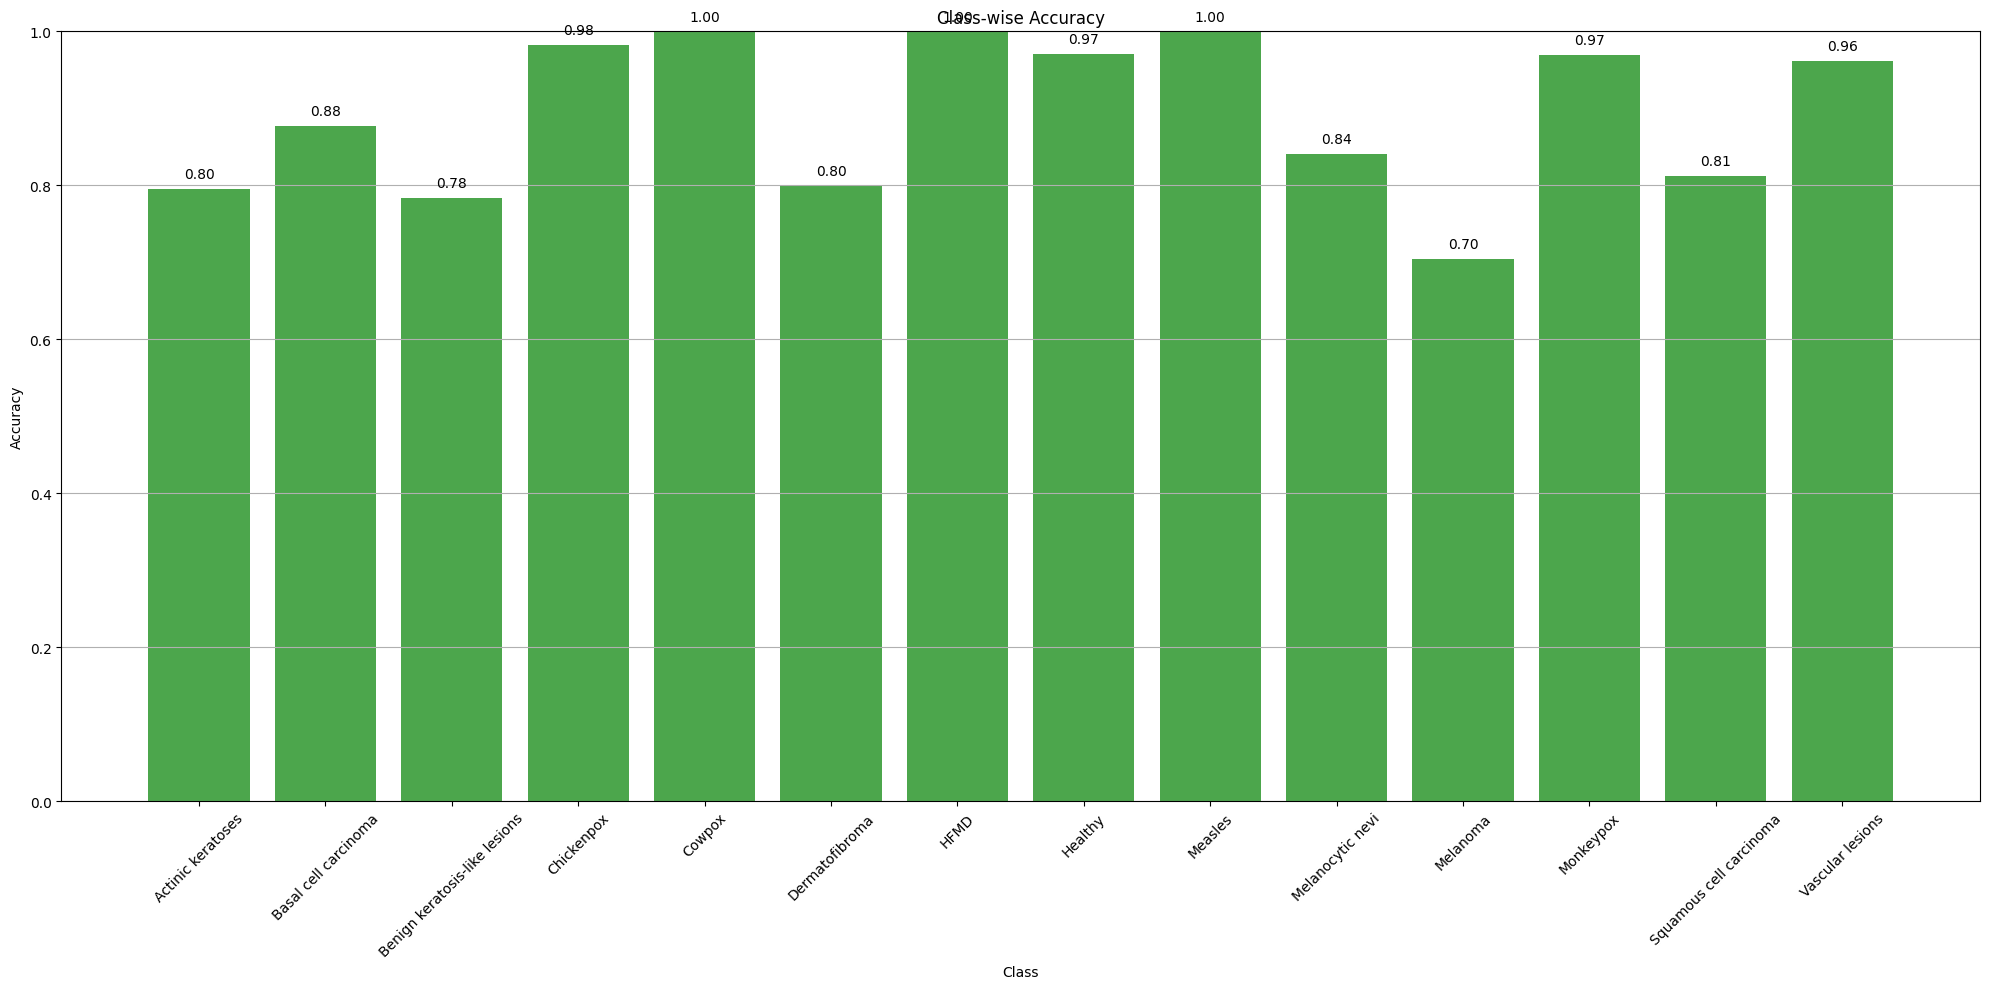

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Assuming class_names is available from earlier cells

# 1. Confusion Matrix and Histogram side by side (2 per row)
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Enhanced Confusion Matrix (left)
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=axes[0], xticks_rotation=45)
axes[0].set_title('Normalized Confusion Matrix')

# Histogram of Prediction Confidences (right)
top_probs = [np.max(p) for p in probs]
axes[1].hist(top_probs, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[1].set_xlabel('Prediction Confidence')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Prediction Confidences')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 2. Class-wise Accuracy as separate plot
plt.figure(figsize=(20, 10))
class_accuracies = []
for i in range(len(class_names)):
    mask = np.array(y_true) == i
    if np.sum(mask) > 0:
        acc = np.mean(np.array(y_pred)[mask] == i)
    else:
        acc = 0
    class_accuracies.append(acc)

plt.bar(range(len(class_names)), class_accuracies, color='green', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add accuracy values on top of bars
for i, v in enumerate(class_accuracies):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()